In [45]:
import numpy as np
import pandas as pd
import typing as tp
import warnings

from copy import deepcopy
from pathlib import Path

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso, Ridge
from tqdm.auto import tqdm


from etna.datasets.tsdataset import TSDataset
from etna.transforms import (
    LagTransform,
    LogTransform,
    MeanTransform
)

from etna.metrics import MAE

from etna.models import(
    NaiveModel,
    CatBoostPerSegmentModel,
    TBATSModel,
    LinearPerSegmentModel,
    ElasticPerSegmentModel,
    SklearnPerSegmentModel,
    SARIMAXModel
) # or any other model you would like to test

from etna.pipeline import Pipeline

import sys
lib_path = Path().resolve().parent / 'lib'
sys.path.insert(0, str(lib_path))
import economica as econ
import etna_utils
import seasonality_utils

from etna_utils.transforms import TsIntegrateTransform
from etna_utils.regression_models import (
    ARDPerSegmentModel,
    RandomForestRegressorPerSegmentModel
)

# %load_ext autoreload
# %autoreload 2

In [46]:
warnings.filterwarnings("ignore")

from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [47]:
pd.infer_freq = lambda df, warn = False: 'MS' # fix some bug to work with month only data
FAILED_LOG_PATH = Path('logs') / 'failed.log'
PATH_RESULTS = Path() / 'etna experiments' / 'results'
PATH_DATA_RAW = PATH_RESULTS.resolve().parent.parent.parent / 'raw_data'
PATH_PROCESSED_DATA = PATH_RESULTS.resolve().parent.parent.parent / 'processed_data'

In [48]:
# some usefull functions

from IPython.display import display

def head_tail(df: pd.DataFrame, n=1) -> None:
    """
    Displays some first and last rows
    Args:
        df (_type_): 
        n (int, optional): number of top and bottom rows to display
    """
    # dfdot = pd.DataFrame(data = ['...'] * df.shape[1], columns=df.columns)
    dfdot = df.head(1)
    dfdot[df.columns] = '...'
    dfdot.index = ['...']
    tdf = pd.concat([df.head(n), dfdot, df.tail(n)])
    display(tdf)


def add_ser_to_ts(
        ts: TSDataset,
        ser: pd.Series,
        segment: str
    ) -> None:
    """adds one pd.Series to ts

    Args:
        ts (TSDataset): dataset to add series to
        ser (pd.Series): series to add
        segment (str):
    """
    df = ser.to_frame().reset_index(names='timestamp')
    df['segment'] = segment
    df = TSDataset.to_dataset(df)

    ts.add_columns_from_pandas(df, update_exog=True)


def cut_date(
        ts: TSDataset,
        end_date = pd.to_datetime('2019-06-01')
    ) -> TSDataset:
    """For given end_date cuts dataset to this date

    Args:
        ts (TSDataset): 
        end_date (_type_, optional):

    Returns:
        TSDataset: new dataset
    """
    return TSDataset(
        ts.raw_df[: end_date]
        ,df_exog=ts.df_exog[: end_date]
        ,freq='MS'
        ,known_future=[]
    )


In [49]:
# functions to aggregate forecasts

def prepare_weights(
        cpi_df: pd.DataFrame,
        init_weights_df: pd.DataFrame,
):
    """

    Args:
        cpi_df (pd.DataFrame): contains % MoM data for every CPI component
        init_weights_df (pd.DataFrame): constains Roostat weights for every CPI component
    """
    
    def get_price_df(inf_df):
        weights_df = (1 + inf_df / 100).cumprod()
        weights_df = weights_df.shift()
        weights_df.fillna(1, inplace=True)
        return weights_df
    
    weights_df = cpi_df.groupby(by=lambda ind: ind.year).apply(get_price_df)
    weights_df = weights_df * init_weights_df

    weights_df = weights_df.apply(lambda row: row / np.nansum(row), axis=1)
    return weights_df


def agg_laspeires(
        cpi_df: pd.DataFrame,
        init_weights_df: pd.DataFrame
    ) -> pd.Series:
    """Aggregates 

    Args:
        cpi_df (pd.DataFrame): _description_
        init_weights_df (pd.DataFrame): _description_

    Returns:
        pd.Series: _description_
    """
    weights_df = prepare_weights(cpi_df, init_weights_df)
    # res = (cpi_mom500_df[cols500] * weights_df).sum(axis=1)
    res = (cpi_df * weights_df).sum(axis=1)
    return res

In [50]:
# this corresponds to train test split at 2019.01.01
N_FOLDS = 55


## Load vars

In [51]:
cpi_mom_df = pd.read_excel(
    PATH_DATA_RAW / 'ConsumerInflationFullGood.xlsx',
    sheet_name='CPIMOM',
)
head_tail(cpi_mom_df)

,Unnamed: 0,CPI
0,2003-01-01 00:00:00,2.4
...,...,...
246,2023-07-01 00:00:00,0.63


In [52]:
cpi_mom_full_df = etna_utils.load_data_utils.load_cpi_full()
# cpi_mom_full_df['CPI'] = cpi_mom_df['CPI']
head_tail(cpi_mom_full_df)

,Food,Meat,Fish,Oils&Fats,Milk,Cheese,Eggs,Sugar,Confectionery,Tea&Coffee,...,Communication Services: Postal,Tourism Services: International,HU: Hotels & Other Lodging,Excursion Services,Veterinary Services,Legal Services,Bank Services,Insurance Services,Sports Services,Mediatory & Other Services
2003-01-01 00:00:00,2.51,0.18,1.56,2.06,1.74,3.46,3.46,2.0,1.29,0.69,...,0.06,0.6,2.23,1.71,1.5,0.74,0.0,NaN,2.5,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-01 00:00:00,0.49,0.93,0.58,-0.86,-0.37,-0.53,1.62,4.38,0.01,0.04,...,0.0,3.25,1.25,-1.24,0.73,0.03,1.14,0.05,0.23,0.25


In [42]:
# load other vars
other_dfs_all = etna_utils.load_data_utils.load_others()

<Axes: xlabel='date'>

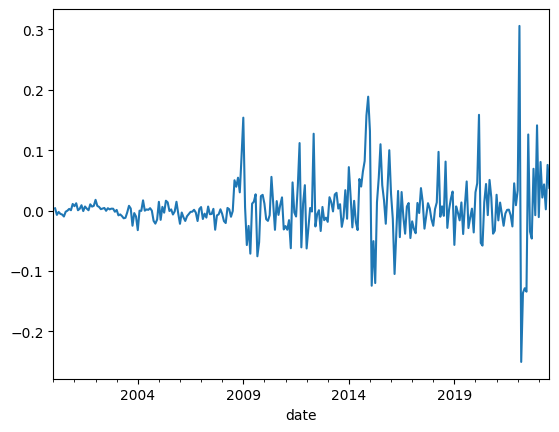

In [43]:
np.log(other_dfs_all['usdrub']['usdrub']['usdrub_month_last']).diff().plot()

# Some functions

In [53]:
import etna

from etna.auto import Tune
from etna.models import CatBoostPerSegmentModel
from etna.transforms.decomposition.deseasonal import DeseasonalityTransform
from etna.transforms import STLTransform
from etna.transforms.math.power import YeoJohnsonTransform

from etna_utils.transforms import TsIntegrateTransform

def ser2ts(ser: pd.Series) -> TSDataset:
    """Transforms pd.Series to TSDataset

    Args:
        ser (pd.Series):

    Returns:
        TSDataset:
    """
    df = ser.to_frame().reset_index()
    df.columns = ['timestamp', 'target']
    df['segment'] = ser.name

    ts = etna.datasets.tsdataset.TSDataset.to_dataset(df)
    ts = etna.datasets.tsdataset.TSDataset(ts, freq='MS')

    return ts

def prep_tsduo(ser: pd.Series) -> TSDataset:
    """Prepares dataset with 2 same columns
    The 2 column will be transformed afterwards

    Args:
        ser (_type_):

    Returns:
        TSDataset: 
    """
    ts = ser2ts(ser)
    tsduo = deepcopy(ts)
    add_ser_to_ts(tsduo, ser.rename('integrated'), ser.name)
    return tsduo

ser = cpi_mom_full_df['Alcohol']


ts = prep_tsduo(ser)

<Axes: xlabel='date'>

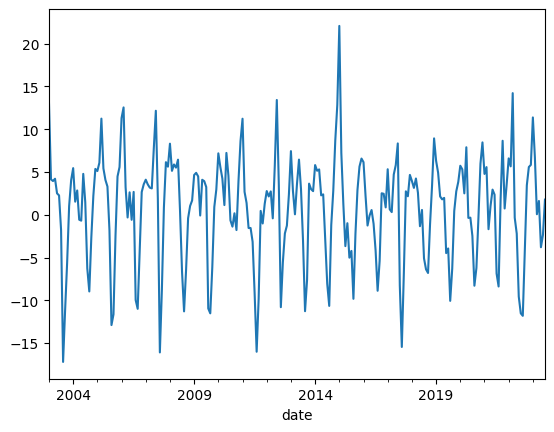

In [54]:
def detrend_deseason(ser):
    ser = seasonality_utils.detrend_stl(ser.dropna())
    ser = seasonality_utils.deseason_stl(ser)
    return ser

ser = cpi_mom_full_df['Fruit&Vegetable']
ser.plot()

# Prepare data

In [55]:
# example

for c in other_dfs_all['usdrub']['usdrub']:
    other_dfs_all['usdrub']['usdrub'][c + '_log'] = np.log(other_dfs_all['usdrub']['usdrub'][c])

# other_dfs_all['usdrub']['usdrub'] = other_dfs_all['usdrub']['usdrub'].iloc[:, :-2]
other_dfs_all['usdrub']['usdrub']

,usdrub_mean,usdrub_month_last,usdrub_mean_log,usdrub_month_last_log
date,,,,
2000-01-01,28.253333,28.5500,3.341211,3.351657
2000-02-01,28.724286,28.6600,3.357743,3.355502
2000-03-01,28.457727,28.4600,3.348420,3.348500
2000-04-01,28.595238,28.4000,3.353240,3.346389
2000-05-01,28.306316,28.2500,3.343085,3.341093
...,...,...,...,...
2023-03-01,76.103586,77.0863,4.332095,4.344926
2023-04-01,80.995543,80.5093,4.394394,4.388373
2023-05-01,79.212595,80.6872,4.372135,4.390580


In [56]:
for c in other_dfs_all['AgricultureFAOPrices']['FAOCEIC']:
    other_dfs_all['AgricultureFAOPrices']['FAOCEIC'][c + '_RUB'] = other_dfs_all['AgricultureFAOPrices']['FAOCEIC'][c] * \
                                                                   other_dfs_all['usdrub']['usdrub']['usdrub_month_last']
    
other_dfs_all['AgricultureFAOPrices']['FAOCEIC']

,World: FAO Food Price Index,World: FAO Meat Price Index,World: FAO Dairy Price Index,World: FAO Cereals Price Index,World: FAO Oils Price Index,World: FAO Sugar Price Index,World: FAO Food Price Index_RUB,World: FAO Meat Price Index_RUB,World: FAO Dairy Price Index_RUB,World: FAO Cereals Price Index_RUB,World: FAO Oils Price Index_RUB,World: FAO Sugar Price Index_RUB
date,,,,,,,,,,,,
1990-01-01,64.145081,73.374551,53.503031,64.140607,44.587672,87.877833,NaN,NaN,NaN,NaN,NaN,NaN
1990-02-01,64.453560,75.956526,52.218634,62.222377,44.500514,90.662693,NaN,NaN,NaN,NaN,NaN,NaN
1990-03-01,63.787064,77.805859,41.367123,61.259884,45.745434,95.056585,NaN,NaN,NaN,NaN,NaN,NaN
1990-04-01,65.766754,80.442049,48.427068,62.820731,44.017094,94.313956,NaN,NaN,NaN,NaN,NaN,NaN
1990-05-01,64.378874,80.994505,39.189651,61.982826,45.499631,90.353264,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-02-01,129.700000,112.100000,131.300000,246.700000,135.900000,125.200000,9783.56931,8455.96083,9904.26099,18609.14841,10251.24957,9444.12396
2023-03-01,126.900000,113.000000,130.300000,138.600000,131.800000,127.000000,9782.25147,8710.75190,10044.34489,10684.16118,10159.97434,9789.96010
2023-04-01,127.700000,116.800000,122.600000,136.100000,130.000000,149.400000,10281.03761,9403.48624,9870.44018,10957.31573,10466.20900,12028.08942


In [57]:
other_dfs_all_d = deepcopy(other_dfs_all)

for names, tser in tqdm(etna_utils.load_data_utils.iter_others(other_dfs_all)):
    other_dfs_all_d[names[0]][names[1]][names[2]] = detrend_deseason(tser)

0it [00:00, ?it/s]

# Forecast all

In [58]:
def preprocess_names(ll: list):
    res = []
    for name in ll:
        if name.endswith('_mean'):
            res.append(name[:-5])
        else:
            res.append(name)
    return res


def get_significant_names(ts, tune):
    ts_copy = deepcopy(ts)
    p = deepcopy(tune.top_k(1)[0])

    p.fit(ts_copy)

    mmt = p.model.get_model()[ser.name]

    ddt = dict(zip(mmt.feature_names_in_, mmt.coef_))
    ddt = dict(sorted({k: v for k, v in ddt.items() if v != 0}.items(), key=lambda it: -np.abs(it[1])))
    res = []
    for n in ddt:
        try:
            res.append(eval(n).in_column)
        except (NameError, AttributeError):
            if 'integrated' in n:
                res.append('integrated')
            if 'target' in n:
                res.append('target')
    
    return list(set(res))


def get_significant_other_names(ts_cuc, tune):
    names = get_significant_names(ts_cuc, tune)
    try:
        names.remove('integrated')
    except ValueError:
        pass
    try:
        names.remove('target')
    except ValueError:
        pass
    return names


def get_params_to_tune(pipe: Pipeline) -> dict:
    p2t = pipe.params_to_tune()
    for k, v in p2t.copy().items():
        if 'robust' in k or 'strategy' in k:
            del p2t[k]
        if 'multiplicative' in str(v):
            del p2t[k]
        if 'per-segment' in str(v):
            del p2t[k]
    return p2t


def run_univariate(
        ser: pd.Series,
        horizon: int,
        tune_nfolds: int = 30,
        tune_n_trials: int = 11,
        backtest_n_folds: int = 55,
        models: tp.Iterable["etna.some_model"] = (ARDPerSegmentModel(verbose=False), ElasticPerSegmentModel())
) -> None:
    # prep ts
    ts = prep_tsduo(ser)

    ts_cut = cut_date(ts)

    #prep transforms
    transforms = [
        TsIntegrateTransform(in_column='integrated'),
        LogTransform(in_column='integrated'),
        STLTransform(in_column='integrated', period=12, robust=True,
                    #   model_kwargs=dict(order=(1, 1, 1))
            stl_kwargs=dict(
                seasonal=15,
                trend=13
            )
        ),
        MeanTransform(in_column='integrated', window=4, alpha=0.9, out_column='integrated_mean'),
        YeoJohnsonTransform(in_column='integrated_mean', standardize=True),
        LagTransform(
            in_column='integrated_mean',
            lags=[horizon],
            out_column='integrated_mean_lag'
        ),

        DeseasonalityTransform(in_column='target', period=12),
        # DensityOutliersTransform(in_column='target', window_size=80, n_neighbors=22, distance_coef=1.9),
        # TimeSeriesImputerTransform(in_column='target', strategy='running_mean', window=1),
        YeoJohnsonTransform(in_column='target', standardize=True),

        MeanTransform(in_column='target', window=3, alpha=0.1),
        LagTransform(
                in_column='target',
                lags=[horizon, horizon + 1],
                out_column='target_lag'
            )
    ]

    # fit
    tunes = []

    for model in models:
        # pipeline
        pipe = Pipeline(
                model=model,
                transforms=transforms,
                horizon=horizon
        )

        # tune
        p2t = get_params_to_tune(pipe)
        tune = Tune(
                pipeline=pipe,
                target_metric=MAE(),
                horizon=horizon,
                backtest_params=dict(
                    n_folds=tune_nfolds,
                    joblib_params=dict(verbose=0),
                    mode='constant',
                    stride=1
                ),
                params_to_tune=p2t
        )
        tune.fit(ts=ts_cut, n_trials=tune_n_trials)
        tunes.append(tune)

    maes = list(map(lambda t: t.summary()['MAE_mean'].values[0], tunes))
    better_tune = tunes[maes.index(min(maes))]

    # backtest
    best_pipe = better_tune.top_k(1)[0]
    m_df, f_df, fold_info_df = best_pipe.backtest(
        ts=ts,
        metrics=[MAE()],
        n_folds=backtest_n_folds,
        joblib_params=dict(verbose=0),
        stride=1,
        mode='constant'
    )

    etna_utils.log_results.save_results(
        ts,
        best_pipe,
        m_df,
        backtest_n_folds,
        f_df,
        fold_info_df,
        target_name=ser.name,
        comment='final univariate pipeline',
        save_figure=True
    )


def prepare_multivariate_transforms(
    var_names,
    horizon: int,
    prepare_integrated=True,
    tr_lags=1,
    target_lags: list = None
):
    if target_lags is None:
        target_lags = [horizon]

    transforms = etna_utils.forecast_utils.prepare_transforms(
        var_names, horizon=horizon,
        prepare_integrated=prepare_integrated, tr_lags=tr_lags
    )
    transforms.extend([
        DeseasonalityTransform(in_column='target', period=12),
        # DensityOutliersTransform(in_column='target', window_size=80, n_neighbors=22, distance_coef=1.9),
        # TimeSeriesImputerTransform(in_column='target', strategy='running_mean', window=1),
        YeoJohnsonTransform(in_column='target', standardize=True),
        MeanTransform(in_column='target', window=3, alpha=0.75, out_column='target_mean'),
        LagTransform(
            in_column='target_mean',
            lags=target_lags,
            out_column='target_mean_lag'
        ),
        # ExogShiftTransform(lag='auto', horizon=horizon)
    ])

    return transforms


def select_multivar_names(
    ser,
    horizon: int,
    other_dfs_all,
    other_dfs_all_d,
    omp_names=19,
    tune_nfolds=30,
    tune_n_trials=7,
    last_date = pd.to_datetime('2019-01-01'),
    models = None,
    second_round: bool = True
) -> list:

    long_names = etna_utils.forecast_utils.select_long_series(other_dfs_all_d)
    ts_omp = etna_utils.forecast_utils.prepare_ts_all(ser, other_dfs_all_d, long_names, exog_df_shift=1)
    var_names = etna_utils.forecast_utils.choose_vars_omp(ser, ts_omp, omp_n_nonzero=omp_names)
    var_names = etna_utils.forecast_utils._find_names(other_dfs_all_d, var_names)

    # prep ts
    ts_cut = etna_utils.forecast_utils.prepare_ts_subset(
        ser,
        other_dfs_all,
        var_names,
        last_date
    )

    transforms = prepare_multivariate_transforms(var_names, horizon, prepare_integrated=True)

    tunes = []
    if models is None:
        models = [ARDPerSegmentModel(verbose=False), ElasticPerSegmentModel()]
    # models = [ARDPerSegmentModel(verbose=False)]
    # model
    for model in models:

        # pipeline
        pipe = Pipeline(
                model=model,
                transforms=transforms,
                horizon=horizon
        )

        # tune
        p2t = get_params_to_tune(pipe)
        tune = Tune(
                pipeline=pipe,
                target_metric=MAE(),
                horizon=horizon,
                backtest_params=dict(
                    n_folds=tune_nfolds,
                    joblib_params=dict(verbose=0),
                    mode='constant',
                    stride=1
                ),
                params_to_tune=p2t
        )
        tune.fit(ts=ts_cut, n_trials=tune_n_trials)
        tunes.append(tune)

    maes = list(map(lambda t: t.summary()['MAE_mean'].values[0], tunes))
    better_tune = tunes[maes.index(min(maes))]

    # 2 round
    selected_names = get_significant_other_names(ts_cut, better_tune)
    selected_names = preprocess_names(selected_names)
    
    if not second_round:
        return selected_names
    
    var_names = etna_utils.forecast_utils._find_names(other_dfs_all, selected_names)
    if var_names:
        ts_cut = etna_utils.forecast_utils.prepare_ts_subset(
            ser,
            other_dfs_all,
            var_names,
            last_date
        )
    else:
        ts_cut = prep_tsduo(ser)

    transforms = prepare_multivariate_transforms(var_names, horizon, prepare_integrated=True)
    tunes = []
    for model in models:
	# model = ARDPerSegmentModel()

        # pipeline
        pipe = Pipeline(
                model=model,
                transforms=transforms,
                horizon=horizon
        )

        # tune
        p2t = get_params_to_tune(pipe)
        tune = Tune(
                pipeline=pipe,
                target_metric=MAE(),
                horizon=horizon,
                backtest_params=dict(
                    n_folds=tune_nfolds,
                    joblib_params=dict(verbose=0),
                    mode='constant',
                    stride=1
                ),
                params_to_tune=p2t
        )
        tune.fit(ts=ts_cut, n_trials=tune_n_trials)
        tunes.append(tune)

    maes = list(map(lambda t: t.summary()['MAE_mean'].values[0], tunes))
    better_tune = tunes[maes.index(min(maes))]
 
    selected_names = get_significant_other_names(ts_cut, better_tune)
    selected_names = preprocess_names(selected_names)

    return selected_names


def run_multivariate(
    ser,
    horizon: int,
    other_dfs_all,
    selected_names: list,
    tune_nfolds=30,
    tune_n_trials=15,
    backtest_n_folds=55,
    last_date = pd.to_datetime('2019-01-01'),
    models: tp.Optional[tp.List["etna.some_model"]] = None
    ):
    names_tuples = etna_utils.forecast_utils._find_names(other_dfs_all, selected_names)

    ts = etna_utils.forecast_utils.prepare_ts_subset(
        ser,
        other_dfs_all,
        names_tuples,
        ser.index[-1]
    )

    ts_cut = etna_utils.forecast_utils.prepare_ts_subset(
        ser,
        other_dfs_all,
        names_tuples,
        last_date
    )

    # transforms
    # transforms = etna_utils.forecast_utils.prepare_transforms(
    #     names_tuples, prepare_integrated=True, tr_lags=1
    # )
    
    # transforms.extend([
    #     DeseasonalityTransform(in_column='target', period=12),
    #     # DensityOutliersTransform(in_column='target', window_size=80, n_neighbors=22, distance_coef=1.9),
    #     # TimeSeriesImputerTransform(in_column='target', strategy='running_mean', window=1),
    #     YeoJohnsonTransform(in_column='target', standardize=True),
    #     MeanTransform(in_column='target', window=3, alpha=0.75),
    #     LagTransform(
    #         in_column='target',
    #         lags=2,
    #         out_column='target_lag'
    #     ),

    #     ExogShiftTransform(lag='auto', horizon=horizon)
    # ])

    transforms = prepare_multivariate_transforms(
        names_tuples, horizon,
        prepare_integrated=True, tr_lags=1,
        target_lags=[horizon, horizon + 1]
    )

    tunes = []
    if models is None:
        models = [ARDPerSegmentModel(verbose=False), ElasticPerSegmentModel()]
    for model in models:
	# model = ARDPerSegmentModel()

        # pipeline
        pipe = Pipeline(
                model=model,
                transforms=transforms,
                horizon=horizon
        )

        # tune
        p2t = get_params_to_tune(pipe)
        tune = Tune(
                pipeline=pipe,
                target_metric=MAE(),
                horizon=horizon,
                backtest_params=dict(
                    n_folds=tune_nfolds,
                    joblib_params=dict(verbose=0),
                    mode='constant',
                    stride=1
            ),
            params_to_tune=p2t
        )
        tune.fit(ts=ts_cut, n_trials=tune_n_trials)
        tunes.append(tune)

    maes = list(map(lambda t: t.summary()['MAE_mean'].values[0], tunes))
    better_tune = tunes[maes.index(min(maes))]

    # pipeline
    best_pipe = better_tune.top_k(1)[0]
    m_df, f_df, fold_info_df = best_pipe.backtest(
        ts=ts,
        metrics=[MAE()],
        n_folds=backtest_n_folds,
        joblib_params=dict(verbose=0),
        mode='constant',
        stride=1
	)

    etna_utils.log_results.save_results(
        ts,
        best_pipe,
        m_df,
        backtest_n_folds,
        f_df,
        fold_info_df,
        target_name=ser.name,
        comment=f'final multivariate pipeline\nnames:\n{selected_names}',
        save_figure=True
	)


<Axes: xlabel='date'>

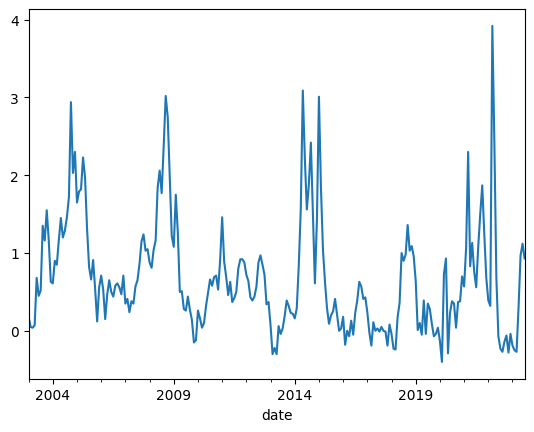

In [59]:
ser = cpi_mom_full_df['Meat']
ser.plot()

In [60]:
import logging

logging.basicConfig(
    filename='run_log_cb.log',
    filemode='a',
    format='%(asctime)s,%(msecs)d %(levelname)s %(message)s',
    datefmt='%Y:%m:%d-%H:%M:%S',
    level=logging.DEBUG
)

In [ ]:
import gc

for horizon in [1, 2, 3, 6, 12, 24]:
    for name in cpi_mom_full_df:
        try:
            gc.collect()
            ser = cpi_mom_full_df[name]
            run_univariate(
                ser.rename(
                    ser.name.replace(':', '_')
                ),
                horizon,
                tune_n_trials=13,
                backtest_n_folds=57,
                models=[CatBoostPerSegmentModel()] # or any other model
            )
            logging.info(f'run {ser.name}, h={horizon}')
        except Exception as e:
            logging.error(f'failed {ser.name}, h={horizon}')


In [ ]:
import gc

for horizon in [1, 2, 3, 6, 12, 24]:
    for name in cpi_mom_full_df:
        try:
            gc.collect()
            ser = cpi_mom_full_df[name]

            names = select_multivar_names(
                ser, horizon, other_dfs_all,
                other_dfs_all_d, tune_nfolds=15, tune_n_trials=5,
                omp_names=4,
                models = [ElasticPerSegmentModel()]
            )
            logging.info(f'finished select names {ser.name}, h={horizon}')
        except Exception as e:
            logging.error('failed select names {ser.name}, h={horizon}')

        try:
            run_multivariate(
                ser.rename(
                    ser.name.replace(':', '_')
                ),
                horizon,
                other_dfs_all,
                tune_n_trials=15,
                backtest_n_folds=57,
                models=[CatBoostPerSegmentModel()]
            )
            logging.info(f'run {ser.name}, h={horizon}')
        except Exception as e:
            logging.error(f'failed {ser.name}, h={horizon}')

# Prepare backtest (insample) forecasts

# Insample forecast (backtest)

In [ ]:
import pathlib
import pickle

from dataclasses import dataclass
from etna.transforms import TimeSeriesImputerTransform

@dataclass
class ForecastData:
    target_name: str
    forecast_df: pd.DataFrame
    metrics_df: pd.DataFrame
    fold_info_df: pd.DataFrame
    pipeline_info: dict
    path: str
    agg_mae: tp.Optional[float] = None
    metrics_insample_df: tp.Optional[pd.DataFrame] = None
    forecast_insample_df: tp.Optional[pd.DataFrame] = None
    fold_info_insample_df: tp.Optional[pd.DataFrame] = None


def read_from_folder(folder: pathlib.Path) -> ForecastData:
    with open(folder / 'forecast.pkl', 'rb') as f:
        forecast_df = pickle.load(f)

    with open(folder / 'metrics.pkl', 'rb') as f:
        metrics_df = pickle.load(f)

    with open(folder / 'info.json', 'r') as f:
        pipeline_info = json.load(f)

    with open(folder / 'fold_inf.pkl', 'rb') as f:
        fold_info_df = pickle.load(f)

    try:
        with open(folder / 'metrics_insample.pkl', 'rb') as f:
            metrics_insample_df = pickle.load(f)
    except FileNotFoundError:
        metrics_insample_df = None

    try:
        with open(folder / 'forecast_insample.pkl', 'rb') as f:
            forecast_insample_df = pickle.load(f)
    except FileNotFoundError:
        forecast_insample_df = None

    try:
        with open(folder / 'fold_inf_insample.pkl', 'rb') as f:
            fold_info_insample_df = pickle.load(f)
    except forecast_insample_df:
        fold_info_insample_df = None

    target_name = pipeline_info['target_name']

    return ForecastData(
        target_name,
        forecast_df,
        metrics_df,
        fold_info_df,
        pipeline_info,
        str(folder),
        metrics_insample_df=metrics_insample_df,
        forecast_insample_df=forecast_insample_df,
        fold_info_insample_df=fold_info_insample_df
    )


def load_pipe(folder: Path) -> Pipeline:
    with open(folder / 'pipe.pkl', 'rb') as f:
        pipeline = pickle.load(f)
    return pipeline


def load_pipes(
    pipes_paths: tp.Dict[tp.Tuple[str, int], str]
):
    res = {k: load_pipe(Path(path)) for k, path in tqdm(pipes_paths.items(), leave=False)}
    return res



def select_vars(
    pipe: Pipeline,
    other_dfs_all
) -> tp.List[tp.Tuple[str, str, str]]:
    def collect_other_names(p: Pipeline):
        names = []
        for t in p.transforms:
            if t.in_column not in ('integrated', 'target'):
                if isinstance(t.in_column, str):
                    names.append(t.in_column)
                elif isinstance(t.in_column, list):
                    names.extend(t.in_column)
                else:
                    raise NotImplementedError
        f_names = []
        f_names = [n for n in names if not n.endswith('_mean') and n not in ('integrated', 'target')]
        return list(set(f_names))

    names = collect_other_names(pipe)
    names_triplets = etna_utils.forecast_utils._find_names(other_dfs_all, names)

    return names_triplets


def impute_ts(ts: TSDataset) -> TSDataset:
    cols = [c[1] for c in ts.df_exog.columns]

    trs = []
    
    for c in cols:
        trs.append(
            TimeSeriesImputerTransform(in_column=c, strategy='forward_fill')
        )

    ts_copy = deepcopy(ts)

    ts_copy.fit_transform(trs)
    return ts_copy


def prepare_ts(
    ser,
    other_dfs_all,
    names_triplets: tp.Iterable[tp.Tuple[str, str, str]],
    pipe: Pipeline
) -> TSDataset:
    ts = etna_utils.forecast_utils.prepare_ts_all(
        ser,
        other_dfs_all,
        names_triplets,
    )

    ts = impute_ts(ts)
    t_name = ts.segments[0]
    for c in ts.df_exog[t_name]:
        ts.df_exog[(t_name, c)] = ts.to_pandas()[t_name][c]
    
    ts = etna_utils.prepare_data.tsdataset_dropna(ts)
    
    # add integrated
    def has_integrated(pipe: Pipeline):
        for t in pipe.transforms:
            if t.in_column == 'integrated':
                return True
        return False
    
    if has_integrated(pipe) and 'integrated' not in ts.to_pandas()[t_name].columns:
        ts = deepcopy(ts)
        ser = ts.to_pandas()[t_name]['target']
        add_ser_to_ts(ts, ser.rename('integrated'), t_name)
    
    return ts
    

def run_backtest_insample(
    ts,
    pipe: Pipeline,
    num_months_from2019: int = 12 * 3, # 3 years
    refit=False
) -> tp.Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    m_df, f_df, fold_info_df = pipe.backtest(
        ts=ts,
        metrics=[etna.metrics.MAE()],
        n_folds = 57 + num_months_from2019,
        joblib_params=dict(verbose=0),
        mode='constant',
        stride=1,
        refit=refit
    )

    return m_df, f_df, fold_info_df


def save_results(
    m_df: pd.DataFrame,
    f_df: pd.DataFrame,
    fold_info_df: pd.DataFrame,
    path: tp.Union[str, Path]
) -> None:
    for df, name in zip(
        [m_df, f_df, fold_info_df],
        ['metrics_insample.pkl', 'forecast_insample.pkl', 'fold_inf_insample.pkl']
    ):
        with open(Path(path) / name, 'wb') as f:
            pickle.dump(df, f)
    

def name_from_path(path):
  return path.split('\\')[2]
